# Final report__MGMT590: Computing for Analytics

# Information of H1B visa petitions around US

Group of:  
    Rong Liao,  
    Shan Lin,   
    Shenyang Yang,  
    Jingda Zhou

### 1.Introduction

### 2.Computional steps

In [465]:
#Import libraries and packages used in this anaysis.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
import datetime
import folium
from folium import plugins
import matplotlib.patches as mpatches

#### 2.1 Read & Reformating

The data used in this analysis was sumbmitted separetly in BlackBoard.
The data was from US Department of Labor, Employment & Training Administration website.
The link from which we downloaded the data is https://www.foreignlaborcert.doleta.gov/pdf/PerformanceData/2017/H-1B_Disclosure_Data_FY17.xlsx. 
But we have converted the file into csv format prior to our analysis.
Please add the attched file in BlackBoard to your work folder.
The date contains 528146 rows and 40 columns.

In [316]:
#Read the data file as csv format. To shorten the time needed, we are reading it chunck by chunck.
#Turn string into numerical data by "thousands=','"
data_iterator=pd.read_csv("H-1B_2017.csv", iterator=True,thousands=',',index_col=False, chunksize=100000)
H1b = pd.concat(data_iterator, ignore_index=True)

/Users/yangshenyang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.
/Users/yangshenyang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.
/Users/yangshenyang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.


In [322]:
print H1b.shape

(528146, 40)


Change the format of the cloumn:'CASE_SUBMITTED' and 'DECISION_DATE' into datetime formate and create two new columns:'Submit' and 'Decision'.

In [323]:
def getFullDate1(row):
    date = datetime.datetime.strptime(row['CASE_SUBMITTED'], "%m/%d/%y")
    return date
H1b["Submit"] = H1b.apply(getFullDate1, axis=1)

In [324]:
def getFullDate2(row):
    date = datetime.datetime.strptime(row["DECISION_DATE"], "%m/%d/%y")
    return date
H1b["Decision"] = H1b.apply(getFullDate2, axis=1)

In [325]:
#change salary to numbers
H1b.head(3)

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_ADDRESS,EMPLOYER_CITY,...,WAGE_UNIT_OF_PAY,H-1B_DEPENDENT,WILLFUL_VIOLATOR,WORKSITE_CITY,WORKSITE_COUNTY,WORKSITE_STATE,WORKSITE_POSTAL_CODE,ORIGINAL_CERT_DATE,Submit,Decision
0,I-200-16055-173457,CERTIFIED-WITHDRAWN,2/24/16,10/1/16,H-1B,8/10/16,8/10/19,DISCOVER PRODUCTS INC.,2500 LAKE COOK ROAD,RIVERWOODS,...,Year,N,N,RIVERWOODS,LAKE,IL,60015,3/1/16,2016-02-24,2016-10-01
1,I-200-16064-557834,CERTIFIED-WITHDRAWN,3/4/16,10/1/16,H-1B,8/16/16,8/16/19,DFS SERVICES LLC,2500 LAKE COOK ROAD,RIVERWOODS,...,Year,N,N,RIVERWOODS,LAKE,IL,60015,3/8/16,2016-03-04,2016-10-01
2,I-200-16063-996093,CERTIFIED-WITHDRAWN,3/10/16,10/1/16,H-1B,9/9/16,9/9/19,EASTBANC TECHNOLOGIES LLC,1211 31ST ST. NW,WASHINGTON,...,Year,Y,N,WASHINGTON,NaN,DC,20007,3/16/16,2016-03-10,2016-10-01


#### 2.2 General information about the H1B petitions

##### 2.2.1 Petition status

In [318]:
#numbers of certified and denide visa
H1b.groupby('CASE_STATUS').CASE_NUMBER.count()

CASE_STATUS
CERTIFIED              468970
CERTIFIED-WITHDRAWN     36171
DENIED                   6989
WITHDRAWN               16016
Name: CASE_NUMBER, dtype: int64

We could see that around 89% of the all the petitions were certified in 2017.

##### 2.2.2 Issue time difference between certified and denied petitions

The issue time is the time between a petition was submitted and a decision was made.

In [326]:
H1b['Issue_Time']=H1b['Decision']-H1b['Submit']

We have found out that some of the petitions has a significtanly longer processing time (eg: longer than a year).This is because the petition was withdrawed by some reason after it was first certified in the previous year.
In this case we will only consider the first time petition filed in 2017, which has two status: 'certified' or 'denied'.

In [328]:
#Average precessing time of a certified H1b visa
H1b.loc[H1b['CASE_STATUS']=='CERTIFIED'].Issue_Time.mean()

Timedelta('5 days 17:44:05.762415')

In [329]:
#Average precessing time of a denied H1b visa
H1b.loc[H1b['CASE_STATUS']=='DENIED'].Issue_Time.mean()

Timedelta('4 days 01:30:14.680211')

By comparing the processing time, we find out that it takes longer to issue a certified petition than a denied petition.

##### 2.2.3 Salary difference between certified and denied petitions

In [334]:
#Average salary of a certified H1b visa.
H1b.loc[H1b['CASE_STATUS']=='CERTIFIED'].WAGE_RATE_OF_PAY_FROM.mean()

82042.45619641014

In [335]:
#Average salary of a denied H1b visa.
H1b.loc[H1b['CASE_STATUS']=='DENIED'].WAGE_RATE_OF_PAY_FROM.mean()

68690.12037773646

By comparing the average salary, we find out that the petition is more likely to be denied with a lower salary.

##### 2.2.4 Full-time and part-time petitions

In [336]:
#Number of part time and full time jobs
H1b.groupby('FULL_TIME_POSITION').CASE_NUMBER.count()

FULL_TIME_POSITION
N     12197
Y    515945
Name: CASE_NUMBER, dtype: int64

We have found that 97.7% of the petitions are filed with a full-time job, but there's still chance that some companies are willing to sponsor a part-time job. 

##### 2.2.5 Job oppurtunity vs. locations

To have a general understanding of where those job oppurtunities are, we decided to use a heatmap to demonstrate that. Since the oringal data has the zipcode imformation only, we have found a file of all the US zipcodes with a matching cordinate.

In [290]:
#Read the matching file form the link.
zipToCord=pd.read_csv('https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data')

In [337]:
#Change the data type of worksite zipcodes into numerical.
H1b.WORKSITE_POSTAL_CODE=pd.to_numeric(H1b.WORKSITE_POSTAL_CODE,errors=coerce)

In [338]:
#Mactching the zipcode with the cordinates.
H1bzip=pd.merge(H1b,zipToCord,left_on=['WORKSITE_POSTAL_CODE'],right_on=['ZIP'],how='inner')

In [ ]:
#Creating heatmap.
H1b_heatmap = folium.Map(location=[38.0000, -97.0000], zoom_start=3)#show a specific location
H1b_heatmap.add_children(plugins.HeatMap([[row["LAT"], row["LNG"]] for name, row in H1bzip.iloc[:].iterrows()],blur=0.00001,min_opacity=.00001))
H1b_heatmap.save("H1bheatmap1.html")
H1b_heatmap

#### 2.3  Location information about H1B petitions 

##### 2.3.1 Petition amount vs. states

In the dataset the salary was recorded in different units, most of them are yearly salary, but some are recorded in smaller units. We would like to see how many different units are there and how many are they.

In [393]:
H1b.groupby('PW_UNIT_OF_PAY').CASE_NUMBER.count()

PW_UNIT_OF_PAY
Bi-Weekly        47
Hour          33108
Month           263
Week            123
Year         494570
Name: CASE_NUMBER, dtype: int64

Five different units of salary were stored in the oringinal data.  
Since most of the petition salaries are recorded in a yearly manner, we will only look at the yearly salaries petitions (i.e.full-time positions).  

Then we will see the number of petitions from each different states.

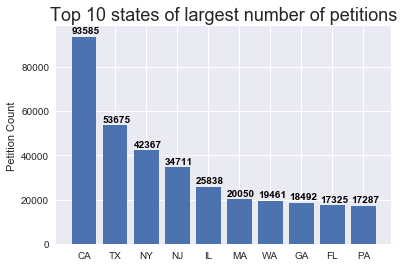

In [433]:
#Group all the petitions by states, and calculate the number of the petitions in the state.
ySalary=H1b[H1b.PW_UNIT_OF_PAY=='Year'] 
statePetition=ySalary.groupby('WORKSITE_STATE')['PREVAILING_WAGE'].agg(['count'])
statePetition.sort_values(by='count', inplace=True, ascending=False)
#Plot the bar chart of state vs. petition amount
state= statePetition.index.values[:10]
info = statePetition['count'][:10].values
fig, ax = plt.subplots() 
ax.bar([i+1 for i in range(10)], info, tick_label=state)
for i in range(10):
    ax.text(i + .6, info[i] + 1500, str(info[i]), color='black', fontweight='bold')
plt.title('Top 10 states of largest number of petitions',fontsize=18)  
ax.set_ylabel('Petition Count')

California, Texas and New York City,has the largest number of petitions,i.e. they have provided most of the H1b sponsored jobs in 2017. Note that California has provided nearly 18% of all the H1b sponsored jobs in the time period.

##### 2.3.2 Salary statistic vs. states

In this section we will look into some details about the salary in each state.  
First we would like to compare the number of petitions and the average salary among the top 10 states.

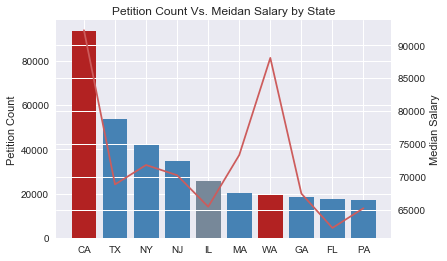

In [434]:
# Get the salary median of the top 10 state with most petitions.
ySalary=H1b[H1b.PW_UNIT_OF_PAY=='Year'] 
statePetition=ySalary.groupby('WORKSITE_STATE')['PREVAILING_WAGE'].agg(['median','count'])
statePetition.sort_values(by='count', inplace=True, ascending=False)
medianSalary=statePetition['median']

y=medianSalary.values[:10]
state= statePetition.index.values[0:10]
#Plot the petition count together with the salary median
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar([i for i in xrange(10)],statePetition['count'].iloc[:10], tick_label=state,
       color=['firebrick','steelblue','steelblue','steelblue','lightslategrey','steelblue','firebrick','steelblue','steelblue','steelblue'])
plt.xlabel('State')
medianSalary=statePetition['median']
y=medianSalary.values[:10]
x=range(len(state))
ax2.plot(x,y, color='indianred')
plt.xticks(x,state)
ax1.set_ylabel('Petition Count')
ax2.set_ylabel('Median Salary')
plt.title('Petition Count Vs. Meidan Salary by State')
plt.show()

Bars in the chart represents the H1b petitions.  
The line shows the median salary of each of the top 10 states.  

Now we would like to dig deeper to see which cities provided the most H1b sponsored jobs.  
We also provide a list of top 10 cities with the median salary of each city.

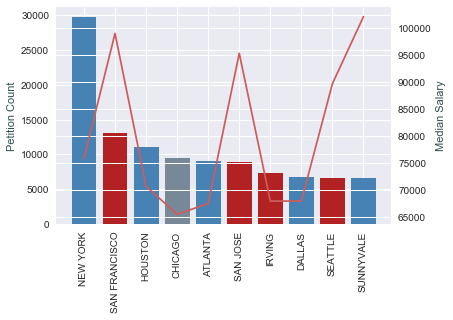

In [428]:
# Get the salary median of the top 10 cities with most petitions.
cityMedian=ySalary.groupby('WORKSITE_CITY')['WAGE_RATE_OF_PAY_FROM'].aggregate([np.mean,np.median])
cityMedian.sort_values(by='median', inplace=True, ascending=False)
cityPetition=ySalary.groupby('WORKSITE_CITY')['PREVAILING_WAGE'].agg(['median','count'])
cityPetition.sort_values(by='count', inplace=True, ascending=False)
city=cityPetition.index.values[:10]
state= statePetition.index.values[0:10]

fig, ax1 = plt.subplots()
locs, labels = plt.xticks()
ax2 = ax1.twinx()
ax1.bar([i for i in xrange(10)],cityPetition['count'].iloc[:10], 
       color=['steelblue','firebrick','steelblue','lightslategrey','steelblue','firebrick','firebrick','steelblue','firebrick','steelblue'])
plt.xlabel('City')
#Plot the petition count together with the salary median
medianSalary=cityPetition['median']
y=medianSalary.values[:10]
x=range(len(city))
ax2.plot(x,y, color='indianred')
plt.xticks(x,city)
plt.setp(labels, rotation=90)
ax1.set_ylabel('Petition Count')
ax2.set_ylabel('Median Salary')
plt.title('Petition Count Vs. Meidan Salary by City')
plt.show()

Among them, 4 cities (highlighted in red) are all in California.Also, those cities,(San Francisco, San Jose, and Mountainview) have higher median salary (90000+) than the other cities.

Another note here, the nearest metropolitan from Purdue University is Chicago (highlight in grey). It ranks fourth in number of petitions, however, its median salary is the lowest compared to the other cities

#### 2.4  Salary information about H1B petitions 

We found that over 90% of petition applicants' salary are paid by year with 87,120 USD as mean and 76,274 USD as median.And still around 30,000 petitioner are paid by hour, which implies some petitioners are part-time workers.

Based on the previous analysis, there are five types of unit: year, month, bi-week, week and hour.Since there are less than 500 of the petitions are recorded by monthly/bi-weekly/weekly pay, we only look at the yearly pay and hourly pay.  

For "Salary by Year" and "Salary by Hour," distribution graphs are affected by few outliers. So we zoomed in where most data gather and readjusted the graphs.  

When we ranked means for yearly and hourly salary from high to low, we found that the highest salary can be 100 times more than the lowest, which showed a wide range of salary distribution among petitioners.

##### 2.4.1 Distribution of yearly salary

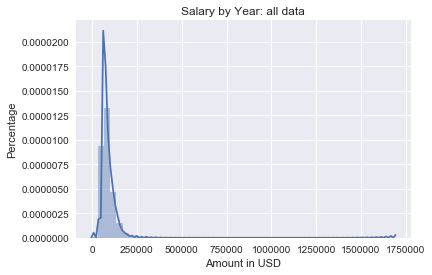

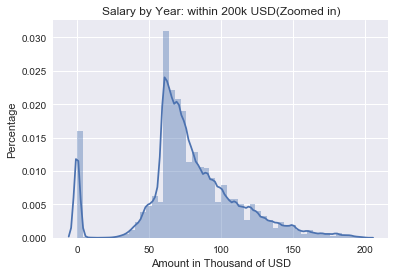

In [444]:
#salary by year(plot 1: all data)
Year_plot = H1b[H1b['WAGE_UNIT_OF_PAY'] == 'Year']['WAGE_RATE_OF_PAY_FROM']
sns.distplot(Year_plot)
plt.title('Salary by Year: all data')
plt.xlabel("Amount in USD")
plt.ylabel("Percentage")
plt.show()
#find out outliers and the range of yearly salary
YearRank = H1b[H1b['WAGE_UNIT_OF_PAY'] == 'Year']['WAGE_RATE_OF_PAY_FROM']
YearRank = YearRank.reset_index()
YearRank.sort_values(['WAGE_RATE_OF_PAY_FROM'],inplace=True, ascending=False)

#salary by year(plot 2: excluding outliers)
Year200k = []
for amount in H1b.WAGE_RATE_OF_PAY_FROM:
        if amount < 200000:
            Year200k.append(amount)

#change the scale of x axis by dividing 1000
Year200k_plot = Year200k
Year200k_plot[:] = [x / 1000 for x in Year200k_plot]
#print Year200k_plot  #Don't check this output list because it's very large!!! It takes time to read.            
sns.distplot(Year200k_plot)   #Will show this graph in powerpoint
plt.title('Salary by Year: within 200k USD(Zoomed in)')
plt.xlabel('Amount in Thousand of USD')
plt.ylabel('Percentage')

##### 2.4.2 Distribution of hourly salary

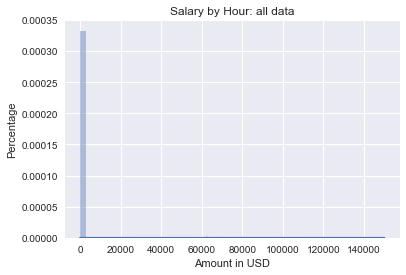

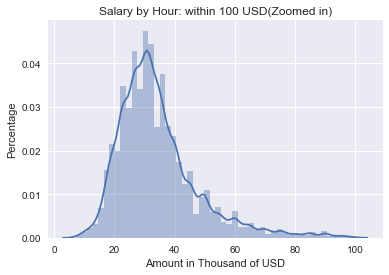

In [445]:
#Salary by Hour(plot1: all data)
Hour_plot = H1b[H1b['WAGE_UNIT_OF_PAY'] == 'Hour']['WAGE_RATE_OF_PAY_FROM']
sns.distplot(Hour_plot)
plt.title('Salary by Hour: all data')
plt.xlabel("Amount in USD")
plt.ylabel("Percentage")
plt.show()
#find out outliers and range of yearly salary
Hour_plot = Hour_plot.reset_index()
Hour_plot.sort_values(['WAGE_RATE_OF_PAY_FROM'],inplace=True, ascending=False)
#Salary by Hour(plot2: excluding outliers)
HourNew = []
for amount in Hour_plot.WAGE_RATE_OF_PAY_FROM:
        if amount < 100:
            HourNew.append(amount)
sns.distplot(HourNew)
plt.title('Salary by Hour: within 100 USD(Zoomed in)')
plt.xlabel('Amount in Thousand of USD')
plt.ylabel('Percentage')

##### 2.4.3 Occupational factors that affect salary

#### Occupational Salary Rank
* Petition cases and salary mean for Occupation Groups
* Petition cases and salary mean for Occupation Titles

<br>To narrow down job hunting scope, we tried to analyze petitioners by their occupational type, which is characterized by SOC_CODE and SOC_NAME. SOC stands for Standard Occupational Classification and we referred to this website for definition:
https://www.bls.gov/soc/major_groups.htm

<br>We found that the top five occupation groups having the most petition cases are:
* Computer and Mathematical Occupations
* Business and Financial Operations Occupations
* Architecture and Engineering Occupations
* Management Occupations
* Life, Physical, and Social Science Occupations

<br>However, computer science related positions are not the best-paying job. "PHYSICIANS AND SURGEONS" ranks the highest among petitioners with a average salary of 450,000. The other four high salary jobs are also healthcare related profession:
* PHYSICIANS AND SURGEONS
* SURGEONS
* ANESTHESIOLOGISTS
* NEUROLOGISTS
* HEALTH SPECIALITY TEACHERS, POSTSECONDARY

<br>We filtered a list of analysts related positions and ranked their average salary from high to low. We found that financial analysts, management and marketing analysts earn more that other type of analsysts. These are the top five well-paying anlysts:
* FINANCIAL QUANTITATIVE ANALYSTS
* COMPUTER SYTEMS ANALYSTS
* MANAGEMENT ANALYST
* MARKET RESEARCH ANALYSTS AND MARKET SPECIALISTS
* INFORMATION SECURITY ANALYSTS

In [448]:
#Since SOC_CODE is composed of 'XX-XXXX,' so we had to decompose it for further analyzing
#We created a new column for parsing SOC_CODE  (Standard Occupational Classification)
H1b['SOC NEW']=pd.Series(H1b['SOC_CODE']).str.split('-')
#After parsing the SOC_CODE, we had the head of SOC_CODE stored in ['SOC NEW']
H1b['SOC NEW']=pd.Series(H1b['SOC_CODE']).str.split('-',expand=True)

In [451]:
#We renamed SOC_CODE into categorical names according to (https://www.bls.gov/soc/major_groups.htm)
H1b['SOC NEW'].replace({'15':'Computer and Math',
                            '13':'Business and Finance',
                            '17':'Architecture and Engineering',
                            '11':'Management',
                            '19':'Life, Physical, Social Science',
                            '29':'Healthcare Practioners',
                            '25':'Education, Training and Library',
                            '27':'Arts, Entertainment, Sports',
                            '41':'Sales',
                            '23':'Legal',  
                            '21':'Community and Social Services',    
                            '43':'Office and Administrative Support',     
                            '39':'Personal Care and Service',    
                            '35':'Food Preparation and Serving',      
                            '51':'Production',      
                            '53':'Transportation and Material Moving',      
                            '31':'Healthcare Support',   
                            '47':'Construction and Extraction',      
                            '49':'Installation and Maintenance',      
                            '45':'Framing, Fishing, and Forestry',      
                            '37':'Building and Grounds Maintainance',       
                            '33':'Protective Service'}, inplace=True)  

Consider the length of the report,in the code below we commented the print code.  

In [459]:
#Compute petition count for each Occupation Groups
occ_count = H1b.groupby(['SOC NEW'])['CASE_NUMBER'].count()
occ_count = occ_count.reset_index()
occ_count.columns = ['Occupation Group','Petition Cases']  #rename columns
occ_count.sort_values('Petition Cases', inplace=True, ascending=False)
#print occ_count

In [460]:
#Compute wage means for each Occupational Titles
position_salary = H1b.groupby(['SOC_NAME'])['WAGE_RATE_OF_PAY_FROM'].mean()
position_salary = position_salary.reset_index()
position_salary.columns = ['Occupational Title','Salary Mean']
position_salary.sort_values('Salary Mean', inplace=True, ascending=False)
#print position_salary

In [464]:
#check wage means for analyst related titles
analyst=position_salary[position_salary['Occupational Title'].str.contains('ANALYST')]
#print analyst

#### 2.5  Employer and industry information about H1B petitions 

##### 2.5.1 Include NAIC Sector Description

In our raw dataset, the 'NAICS_CODE' represents the industry of every employers. To be more precise, we decide to include the industry description by merging a dataframe (i.e.2-6 digit_2017_Codes.csv)to our dataframe "employer". The merged dataframe is called "emp_with_exp".

The first two digits of the "NAICS_CODE" means the sector of which the employer belongs to. For example, '52' means 'Finance and Insurance'. In our later analysis, we will divide the employers by sectors. We will get the first two digits of the code and saved in a new column called "NAICS Sector". After that, based on the "NAICS Sector", we merge the two dataframes.

In [469]:
#data cleaning
H1b['NAICS_CODE'] = H1b['NAICS_CODE'].astype(str).str.rstrip('.0')
H1b['NAICS Sector'] = H1b['NAICS_CODE'].astype(str).map(lambda x: x[:2])

In [470]:
# for NAICS_Code explanation (sector code only - 2 numbers)
naicsCode = pd.read_csv('2-6 digit_2017_Codes.csv', dtype=str, index_col=False).iloc[1:,1:3]
# to get the 2-digit sector code only, including some range
sectorCode1 = naicsCode.loc[naicsCode['2017 NAICS US   Code'].str.len()==2]
sectorCode2 = naicsCode.loc[naicsCode['2017 NAICS US   Code'].str.contains('-')]
sectorCode3 = []
for s in sectorCode2.values:
    start, end, des = int(s[0][:2]), int(s[0][3:]), s[1]
    for i in xrange(start, end+1):
        sectorCode3.append([i, des])
sectorCode3 = pd.DataFrame(data=np.array(sectorCode3), columns=['2017 NAICS US   Code', '2017 NAICS US Title'])
sectorCode = sectorCode1.append(sectorCode3, ignore_index=True)
sectorCode.columns = ['NAICS Sector', 'NAICS US Title']
emp_with_exp = pd.merge(left=H1b, right=sectorCode, on='NAICS Sector', how='inner') 
emp_with_exp.head() #below shows the merged dataframe with NAICS description.

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_ADDRESS,EMPLOYER_CITY,...,WORKSITE_COUNTY,WORKSITE_STATE,WORKSITE_POSTAL_CODE,ORIGINAL_CERT_DATE,Submit,Decision,Issue_Time,SOC NEW,NAICS Sector,NAICS US Title
0,I-200-16055-173457,CERTIFIED-WITHDRAWN,2/24/16,10/1/16,H-1B,8/10/16,8/10/19,DISCOVER PRODUCTS INC.,2500 LAKE COOK ROAD,RIVERWOODS,...,LAKE,IL,60015.0,3/1/16,2016-02-24,2016-10-01,220 days,Computer and Math,52,Finance and Insurance
1,I-200-16064-557834,CERTIFIED-WITHDRAWN,3/4/16,10/1/16,H-1B,8/16/16,8/16/19,DFS SERVICES LLC,2500 LAKE COOK ROAD,RIVERWOODS,...,LAKE,IL,60015.0,3/8/16,2016-03-04,2016-10-01,211 days,Computer and Math,52,Finance and Insurance
2,I-200-15053-636744,CERTIFIED-WITHDRAWN,2/22/15,10/2/16,H-1B,3/1/15,3/1/18,BB&T CORPORATION,223 WEST NASH STREET,WILSON,...,NEW YORK,NY,10036.0,2/26/15,2015-02-22,2016-10-02,588 days,Business and Finance,52,Finance and Insurance
3,I-200-15071-336195,CERTIFIED-WITHDRAWN,3/12/15,10/2/16,H-1B,9/11/15,9/11/18,"SUNTRUST BANKS, INC.","303 PEACHTREE STREET, NE",ATLANTA,...,FULTON,GA,30303.0,3/18/15,2015-03-12,2016-10-02,570 days,Business and Finance,52,Finance and Insurance
4,I-200-14052-116073,CERTIFIED-WITHDRAWN,2/26/14,10/3/16,H-1B,8/24/14,8/23/17,"AXCESS FINANCIAL SERVICES, INC.",7755 MONTGOMERY ROAD,CINCINNATI,...,HAMILTON,OH,45236.0,3/4/14,2014-02-26,2016-10-03,950 days,Computer and Math,52,Finance and Insurance


We would like to see which employers sponsor more petitioners than others, and get the top 10 of them. We start by grouping the "EMPLOYER_NAME" and count the number of petitions under each name. 

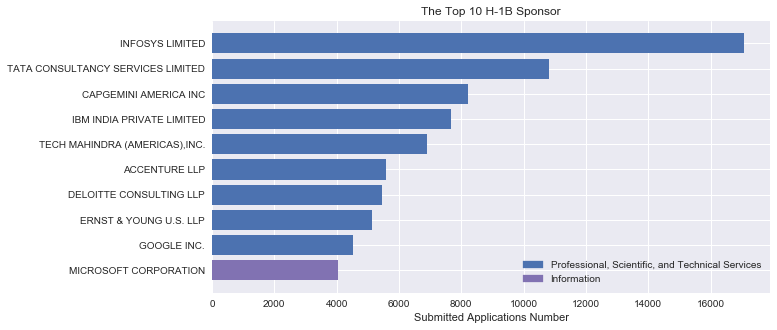

In [471]:
employerdata1 = emp_with_exp.groupby("EMPLOYER_NAME")
employerdata1_Count = employerdata1["CASE_NUMBER"].count()
employer_top = employerdata1_Count.sort_values(ascending=False)[:10]#.index.values
#get top 10 employer
#print employer_top
pEmployer, pCount, pDet = [], [], []
for name, counts in zip(employer_top.index, employer_top):
    pEmployer.append(name) 
    pCount.append(counts)
    pDet.append(emp_with_exp[emp_with_exp['EMPLOYER_NAME']==name]['NAICS US Title'].iloc[0])
    
mycolor = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
colorMatch = {}
for des in pDet[::-1]:
    colorMatch[des] = mycolor.pop()
#print pInd
plt.figure(figsize=(10,5))
mybar = plt.barh([i+1 for i in range(10)], pCount[::-1], tick_label=pEmployer[::-1],
                 color=[colorMatch[pDet[d]] for d in range(10)[::-1]])
mypatch = [mpatches.Patch(color=v, label=k) for k,v in colorMatch.items()]
plt.legend(handles=mypatch)
plt.title('The Top 10 H-1B Sponsor')
plt.xlabel('Submitted Applications Number')
plt.show()    

The graph above shows that 9 of the top 10 employers are from the "Professional, Scientific, and Technical Services" industry. We are interested to explore the reason. Therefore, we try to group the data by "NAICS Sector" as follows.

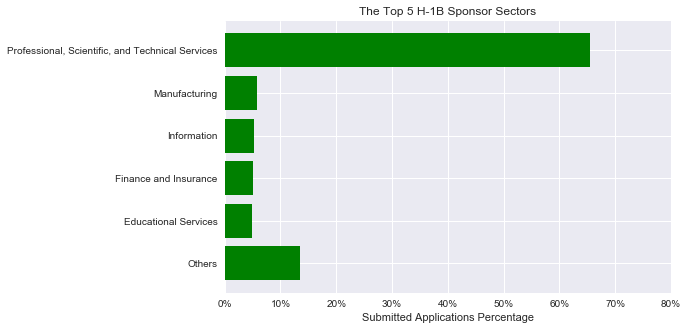

In [484]:
# Create the top 5 industry sector plot
employerdata2 = emp_with_exp.groupby("NAICS Sector")
employerdata2_Count = employerdata2["NAICS Sector"].count()
sector_top = employerdata2_Count.sort_values(ascending=False)[:5]
totaldata = emp_with_exp.shape[0]

pPer, pSect = [], []
for i, counts in zip(sector_top.index, sector_top):
    pSect.append(sectorCode[sectorCode['NAICS Sector']==i]['NAICS US Title'].iloc[0]) 
    pPer.append(float(counts)/totaldata)
pSect.append('Others')
pPer.append(1-sum(pPer))

plt.figure(figsize=(8,5))
mybar = plt.barh([i+1 for i in range(6)], pPer[::-1], tick_label=pSect[::-1], color='green')
plt.title('The Top 5 H-1B Sponsor Sectors')
plt.xticks([0.1*j for j in range(9)], [str(10*i)+'%' for i in range(9)])
plt.xlabel('Submitted Applications Percentage')
plt.show()

The above graph shows the top 5 H-1B sponsors' industry. "Professional, Scientific, and Technical Services" occupies over 60% of the total dataset. From the figure we know that most of the employers who offer H-1B sponser are from this industry. 

We would like to further look into the breakdown of the "Professional, Scientific, and Technical Services" industry to see what are the sub-industries. To achieve this, we further look into the 4 digits of the "NAICS_CODE" to get the detailed sector information. The breakdown is plot in pie.

##### 2.5.2 Beakdown of "Professional, Scientific, and Technical Services"

From the following breakdown, we see that "Computer Systems Design and Related Services" occupies over 70% of the pie chart.

In [474]:
#For division plot in the top sector industry
#naicsCode['NAICS Num'] = pd.to_numeric(naicsCode['2017 NAICS US   Code'],errors='ignore')
i1 = naicsCode[naicsCode['2017 NAICS US   Code']=='54'].index.values[0]-1
i2 = naicsCode[naicsCode['2017 NAICS US   Code']=='55'].index.values[0]-1
detailedCode = naicsCode.iloc[i1:i2,:]
detailedCode.columns=['NAICS_CODE', 'NAICS US Title']
# clean the NAICS_CODE
H1b['NAICS_CODE'] = H1b['NAICS_CODE'].astype(str).str.rstrip('.0')
emp_with_det = pd.merge(left=H1b, right=detailedCode, on='NAICS_CODE', how='inner')
# Get the high-level summary of the detailed NAICS_CODE
emp_with_det['NAICS_CODE_4'] = emp_with_det['NAICS_CODE'].astype(str).str[0:4]
# Count the summarized code appearance
emp_det_count = emp_with_det['NAICS_CODE_4'].value_counts().sort_index()
emp_det_count = list(emp_det_count)[1:]
detailsCode = []
# Get the correct data
for row in detailedCode.values:
    if len(row[0])==4:
        detailsCode.append(row[1])

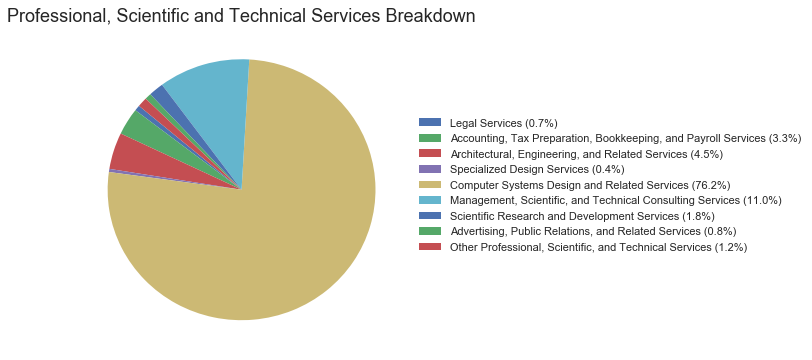

In [477]:
plt.figure(figsize=(6,6))
mycolor = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
slices = plt.pie(emp_det_count, startangle=140, colors=mycolor)
plt.title('Professional, Scientific and Technical Services Breakdown',fontsize=18)
# get percentage
emp_det_count = [float(i)/sum(emp_det_count) for i in emp_det_count]
labels = ['{0} ({1:1.1f}%)'.format(i,100.0*j) for i,j in zip(detailsCode, emp_det_count)] #create a list of labels
plt.legend(slices, labels=labels, bbox_to_anchor=(1, 0.75), fontsize = 11) #Add legend. 
#plt.axis('equal') #so that it is a circle 
plt.show()

##### 2.5.3 Salary Rank by Sectors

We would like to examine if the most popular industry "Professional, Scientific, and Technical Services" also offer the highest salary. We therefore rank the salary by sectors. Here, the "WAGE_RATE_OF_PAY_FROM" is the actual wage offered by the employer.

Since our analysis focus more on the entry and middle level group, we use median salary instead of mean to get rid of influence from extreme figures.

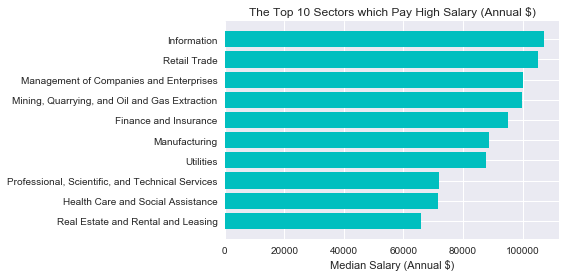

In [478]:
#Median
#group by 'NAICS US Title' 
WageBySector_median = emp_with_exp.groupby(['NAICS US Title'])['WAGE_RATE_OF_PAY_FROM'].median()
WageBySector_median = WageBySector_median.reset_index()
WageBySector_median.columns = ['NAICS US Title','WAGE']
WageBySector_median.sort_values('WAGE',inplace=True, ascending=False)
top10 = WageBySector_median.iloc[:10]

#Plot
label = top10['NAICS US Title']
plt.barh([i+1 for i in range(10)], top10['WAGE'][::-1],tick_label = label[::-1],color = 'c')
plt.title('The Top 10 Sectors which Pay High Salary (Annual $)')
plt.xlabel('Median Salary (Annual $)')
plt.show()

From the above we noted that "Professional, Scientific, and Technical Services" ranks the 8th from the top 10 sectors. We also want to know which industry pay more than the required. Here, the "PREVAILING_WAGE" is the wage required by the government. We calculate the difference between the actual wage ("WAGE_RATE_OF_PAY_FROM") and the government required wage("PREVAILING_WAGE") and sort the top 10 sectors.

##### 2.5.4 Overpay Rank by Sector

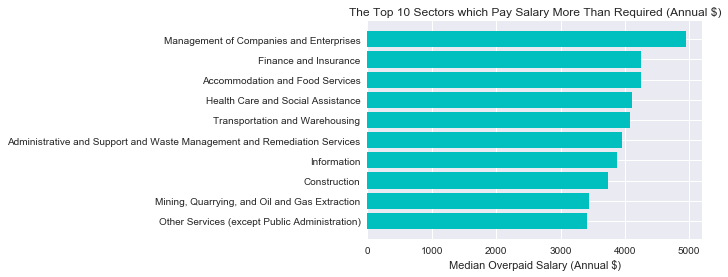

In [482]:
#Over-pay rank by Employer Sector
#Create a new column 'WageRate-PrevWage'
emp_with_exp['WageRate-PrevWage']=H1b.WAGE_RATE_OF_PAY_FROM - H1b.PREVAILING_WAGE

#Group by Employer's Name and computer each MEAN of  (Actual Wage - Prevailing Wage)
PW_median2 = emp_with_exp.groupby(['NAICS US Title'])['WageRate-PrevWage'].median()
PW_median2 = PW_median2.reset_index()
PW_median2.columns = ['NAICS US Title','OverPayorNot']
PW_median2.sort_values('OverPayorNot',inplace=True, ascending=False)
PW_top10 = PW_median2.iloc[:10]
label = PW_top10['NAICS US Title']
plt.barh([i+1 for i in range(10)], PW_top10['OverPayorNot'][::-1],tick_label = label[::-1],color = 'c')
plt.title('The Top 10 Sectors which Pay Salary More Than Required (Annual $)')
plt.xlabel('Median Overpaid Salary (Annual $)')
plt.show()

From the above we noted that "Professional, Scientific, and Technical Services" is not in the top 10 list. The "Management of Companies and Enterprises" industry overpays the most among the all industries. 

#### 2.6 Industries by States (put cluster here, better name later) 

### 3.Conclusion

#### 3.1  Summary 

#### 3.2  Recommendations

In [ ]:
Based

Besides, we have also provided a tool for the users to chose a place to work that fits there requirments the best. We have designed a model, in which, we have considered the salary and job oppurtunity rankings generated in our analysis as well as the crimerate and 'have fun'index of the states from other sources. 
After a user providing his/her own weighting regarding the above factors when chosing a place to work, we could be able to recommend a state with the highest overall score based on the user's critiria.

In [303]:
#Reading the model.
test=pd.read_csv('model2.csv')
test=test.rename(columns={'Job number':'job'})

In [421]:
print ' When chosing your work place, please score the following statement from 1~10: 1--I dont care!   5--Just average~     10--Very important!'

Fun=input('The place cannot be very boring (I need to have some fun).')
job=input('The place needs to have planty of job oppurunities.')
salary=input('The place needs to offer higher salary.')
crime=input('The place need to have a low crime rate.')

score=[]

for index, row in test.iterrows():
    s=(Fun*row['haveFun'])+(job*row['job'])+(salary*row['salary'])+(crime*row['crimmerate'])
    score.append(s)
        
test['score']=score
ranking=test.sort_values(['score'], ascending=[False]).reset_index(drop=True)
print' '
print 'Your first choice is:   ',ranking.iloc[0]['states']   
print 'Your second choice is:   ',ranking.iloc[1]['states']  
print 'Your third choice is:   ',ranking.iloc[2]['states']  

 When chosing your work place, please score the following statement from 1~10: 1--I dont care!   5--Just average~     10--Very important!
The place cannot be very boring (I need to have some fun).5
The place needs to have planty of job oppurunities.7
The place needs to offer higher salary.9
The place need to have a low crime rate.2
 
Your first choice is:    California
Your second choice is:    Washington
Your third choice is:    New York


### 4. Difficulties and future work

#### 4.1  Challenge and difficulties

#### 4.2  Future work